### Resources

- https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
- https://arxiv.org/pdf/1312.5602
- https://www.lesswrong.com/posts/kyvCNgx9oAwJCuevo/deep-q-networks-explained

In [ ]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import gymnasium as gym
import ale_py
import pickle
import matplotlib.pyplot as plt

from collections import deque
from gymnasium.wrappers import FrameStack
from stable_baselines3.common.atari_wrappers import (
    AtariWrapper,
    FireResetEnv,
    EpisodicLifeEnv,
    MaxAndSkipEnv,
)

gym.register_envs(ale_py)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Helper functions

In [3]:
def display_frame(frame, gray=False):
    if gray:
        plt.imshow(frame, cmap='gray')
    else:
        plt.imshow(frame)
    plt.axis('off')
    plt.show()

In [4]:
def display_multiple_frames(frames):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(frames[i], cmap='gray')
        ax.axis('off')
    plt.show()

In [ ]:
def make_env(game, render='rgb_array'):
    env = gym.make(game, render_mode=render)
    env = AtariWrapper(env, terminal_on_life_loss=False, frame_skip=4)
    env = FrameStack(env, num_stack=4)
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)
    if "FIRE" in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    return env

In [6]:
env = make_env('BreakoutNoFrameskip-v4')

Before processing state

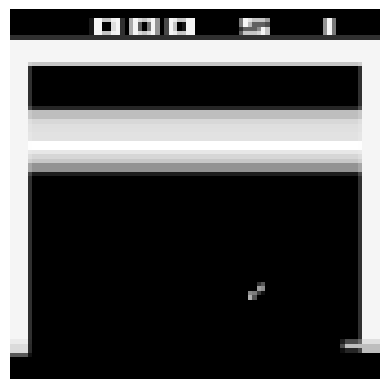

In [7]:
obs, info = env.reset()
display_frame(obs.squeeze()[-1], gray=True)

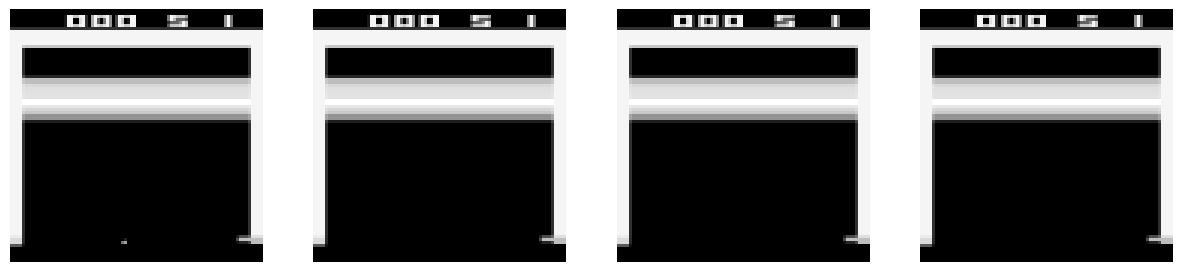

In [8]:
obs, info = env.reset()
display_multiple_frames(obs.squeeze())

### Experience Replay

In [10]:
class ReplayBuffer:

    def __init__(self, capacity) -> None:
        self._buffer_obs = deque(maxlen=capacity)
        self._buffer_acts = deque(maxlen=capacity)
        self._buffer_rs = deque(maxlen=capacity)
        self._buffer_obs_ps = deque(maxlen=capacity)
        self._buffer_dones = deque(maxlen=capacity)

        self._buffers = [self._buffer_obs, self._buffer_acts, self._buffer_rs, self._buffer_obs_ps, self._buffer_dones]

    def store(self, experience: tuple) -> None:
        self._buffer_obs.append(experience[0])
        self._buffer_acts.append(experience[1])
        self._buffer_rs.append(experience[2])
        self._buffer_obs_ps.append(experience[3])
        self._buffer_dones.append(experience[4])

    def sample(self, batch_size, device='cuda'):
        indices = np.random.randint(0, high=len(self), size=(batch_size))
        observations, actions, rewards, obs_primes, dones = self.buffers
        batch_observations, batch_actions, batch_rewards, batch_obs_primes, batch_dones = (
            np.take(observations, indices, axis=0),
            np.take(actions, indices, axis=0).reshape(-1, 1),
            np.take(rewards, indices, axis=0).reshape(-1, 1),
            np.take(obs_primes, indices, axis=0),
            np.take(dones, indices, axis=0).reshape(-1, 1)
        )
        return (
            torch.tensor(batch_observations, dtype=torch.float32).to(device),
            torch.tensor(batch_actions, dtype=torch.int64).to(device),
            torch.tensor(batch_rewards, dtype=torch.float32).to(device),
            torch.tensor(batch_obs_primes, dtype=torch.float32).to(device),
            torch.tensor(batch_dones, dtype=torch.bool).to(device),
        )

    def __len__(self):
        return len(self._buffer_obs)

    def __getitem__(self, index):
        return tuple([buffer[index] for buffer in self._buffers])

    def __setitem__(self, index, value: tuple):
        for i, buffer in enumerate(self._buffers):
            buffer[index] = value[i]

    def shuffle(self):
        np.random.shuffle(self.buffer)

    @property
    def shape(self):
        if len(self._buffer_obs) > 0:
            shape = (len(self._buffer_obs), 5)
            return shape
        else:
            return (0,)

    @property
    def buffers(self):
      npbuffers = [np.array(buffer) for buffer in self._buffers]
      return tuple(npbuffers)

In [11]:
# def check_for_buffer(fname):
#     if os.path.isfile(fname):
#         if os.path.getsize(fname) > 0:
#             with open(fname, 'rb') as f:
#                 buffer = pickle.load(fname)
#                 f.close()
#                 return buffer
#     else:
#         print('File does not exist')
#     return None

# buffer_pong = check_for_buffer('replays/replay1.pkl')

In [12]:
NUM_PRELOADS = 50000
buffer_pong = ReplayBuffer(1000000)

observation, _ = env.reset()
for step in range(NUM_PRELOADS):    
    action = env.action_space.sample()

    observation_prime, reward, terminated, truncated, _ = env.step(action)
    buffer_pong.store((
        observation.squeeze(), 
        action, 
        reward, 
        observation_prime.squeeze(), 
        terminated or truncated))
    observation = observation_prime

    done = terminated or truncated
    if done:
        observation, _ = env.reset()

print(len(buffer_pong))

50000


(4, 84, 84)


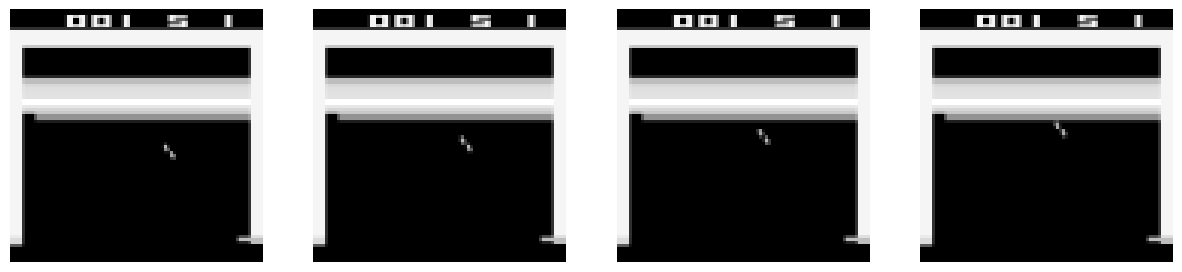

In [13]:
frame = buffer_pong[10][3]
print(frame.shape)
display_multiple_frames(frame)

In [14]:
with open('replays/replay1.pkl', 'wb') as f:
    pickle.dump(buffer_pong, f)
    f.close()

In [ ]:
class DQN(nn.Module):

    def __init__(
        self,
        env,
        in_channels = 4,
        hidden_filters = [16, 32],
        start_epsilon = 0.99,
        max_decay = 0.1,
        decay_steps = 1000,
        *args,
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.start_epsilon = start_epsilon
        self.epsilon = start_epsilon
        self.max_decay = max_decay
        self.decay_steps = decay_steps
        self.env = env
        self.num_actions = env.action_space.n

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, hidden_filters[0], kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(hidden_filters[0], hidden_filters[1], kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(hidden_filters[1] * 9 * 9, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

        self.apply(self._init)

    def _init(self, m):
      if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
          nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.layers(x / 255.0)

    def epsilon_greedy(self, state, dim=1):
        rng = np.random.random()

        if rng < self.epsilon:
            action = self.env.action_space.sample()
            action = torch.tensor(action)
        else:
            with torch.no_grad():
                q_values = self(state)
            
            action = torch.argmax(q_values, dim=dim)

        return action

    def epsilon_decay(self, step):
        self.epsilon = self.max_decay + (self.start_epsilon - self.max_decay) * max(0, (self.decay_steps - step) / self.decay_steps)


: 

Training procedure

In [ ]:
TIMESTEPS = 10000000
LR = 2.5e-4
BATCH_SIZE = 32
C = 1000
GAMMA = 0.99
TRAIN_FREQ = 4
FINAL_ANNEAL = 1000000

q_network = DQN(env, decay_steps=FINAL_ANNEAL).to(device)
target_network = DQN(env, decay_steps=FINAL_ANNEAL).to(device)
target_network.load_state_dict(q_network.state_dict())

loss_func = nn.MSELoss()
optimizer = torch.optim.AdamW(q_network.parameters(), lr=LR)

obs, _ = env.reset()
total_reward = 0
losses = []
rewards_list = []

for step in range(TIMESTEPS):
    
    batched_obs = np.expand_dims(obs.squeeze(), axis=0)
    action = q_network.epsilon_greedy(torch.tensor(batched_obs, dtype=torch.float32).to(device)).cpu().item()
    obs_prime, reward, terminated, trunctated, _ = env.step(action)

    buffer_pong.store((obs.squeeze(), action, reward, obs_prime.squeeze(), terminated or truncated))
    total_reward += reward
    obs = obs_prime
    
    if terminated:
        rewards_list.append(total_reward)
        total_reward = 0
        obs, _ = env.reset()
        continue

    if step % TRAIN_FREQ == 0:
        observations, actions, rewards, observation_primes, dones = buffer_pong.sample(BATCH_SIZE)
        with torch.no_grad():
            q_values_minus = target_network(observation_primes)
            boostrapped_values = torch.amax(q_values_minus, dim=1, keepdim=True)

        y_trues = torch.empty((BATCH_SIZE, 1)).to(device)
        y_trues = torch.where(dones, rewards, rewards + GAMMA * boostrapped_values)
        y_preds = q_network(observations)

        loss = loss_func(y_preds.gather(1, actions), y_trues)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss)
        
    q_network.epsilon_decay(step)
    target_network.epsilon_decay(step)
    
    if step % C == 0:
        target_network.load_state_dict(q_network.state_dict())
    print(f'Step: {step+1}, Loss: {loss:.4f}, Epsilon: {q_network.epsilon:.4f}, Last Episode Reward: {rewards_list[-1] if len(rewards_list) > 0 else 0.0}',
          end='\r',
          flush=True
        )

env.close()

In [ ]:
torch.save(q_network.state_dict(), 'q_net2.pt')

In [ ]:
env_test = make_env('PongNoFrameskip-v4', render='human')

q_network_trained = DQN(env_test)
q_network_trained.load_state_dict(torch.load('q_net1.pt', weights_only=True))
q_network_trained.eval()

DQN(
  (layers): Sequential(
    (0): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=2592, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [ ]:
done = False
total_reward = 0

obs, _ = env_test.reset()
while not done:
    batched_obs = obs[np.newaxis, :, :, :, 0]
    with torch.no_grad():
        logits = q_network_trained(torch.tensor(batched_obs).float())
        action = torch.argmax(logits, dim=1).item()

    next_observation, reward, terminated, truncated, _ = env_test.step(action)
    total_reward += reward
    obs = next_observation

    done = terminated or truncated

env_test.close()
print(f'Total reward achieved: {total_reward}')

Total reward achieved: -21.0
